# Stock Price Prediction Using LSTMs

### Abstract

This notebook explores the use of LSTMs to predict stock prices. We are using LSTMs because they are well suited for time series data. LSTM is a variation of Recurrent Neural Networks that are capable of taking in series of data and selectivly forget data and output a predicted value. We will be using the stock price data of PayPal for training and testing. The data can be downloaded in CSV file with the use of an API provided by alpha vantage(https://www.alphavantage.co/).

### Exploring data

Importing all necessary libraries
The main library used for creating the neural network is Keras
Other libraries like Pandas, Numpy, Sklearn are used to import and work on data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os
from sklearn.model_selection import train_test_split
import pickle

Using TensorFlow backend.


Importing csv file 
We can either import the CSV file using the URL or download the file separatly and then provide the path to that CSV file. 
Please note that the data fetched using the URL will be dynamic as it is live data. So for training and testing purpose we can download the file separatly and then use the CSV file.

In [2]:
#stock_code = "PYPL"
#api_key = ""
#url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock_code+"&apikey="+ api_key +"&datatype=csv&outputsize=full"
#df = pd.read_csv(url)

df = pd.read_csv("daily_PYPL.csv")
df.head()

,timestamp,open,high,low,close,volume
0,2019-07-19,120.74,121.36,118.60,118.63,4913977
1,2019-07-18,118.99,120.80,118.63,119.87,4440672
2,2019-07-17,119.65,119.99,118.80,118.81,4627478
3,2019-07-16,121.10,121.48,119.53,119.71,4006838
4,2019-07-15,120.77,121.04,119.80,120.90,3721345


In [3]:
df.shape

(1008, 6)

We are only going to work with the Open values for the stock so we select just the "Open" Column and reshape the data frame 

In [4]:
df = df['open'].values[:500]
df = df.reshape(-1, 1)

Plotting open Prices for visualizing the data.

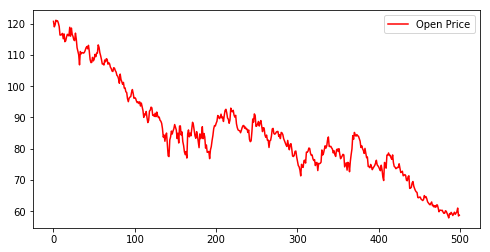

In [5]:
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df, color='red',  label="Open Price")
plt.legend()

### Creating data for training LSTM


The stock price data which we would be using for training and testing will consist of a bunch of 50 sequential values as X and the next value as its corresponding y. So while splitting the data into training and test dataset, the test data has to have the an overlap of 50 sequential values with the training set.

### Creating Training and testing datasets

We split the data into 80% training and 20% testing dataset.


In [6]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(400, 1)
(150, 1)


The data values do not have a specific range and have to be normalized so that it can be feed into the model.
Here we use MinMaxScaler to scale the values between 0 and 1.

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))

Scaling training and testing data

In [8]:
dataset_train = scaler.fit_transform(dataset_train)

In [9]:
dataset_test = scaler.transform(dataset_test)

Creating method for generating dataset with X and y.
Here we bundle 50 sequental values togeter to form a single x which corresponds to a y which will be the next value in the sequence.

In [10]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

Applying the method on train and test data.

In [11]:
x_train, y_train = create_dataset(dataset_train)

In [12]:
x_test, y_test = create_dataset(dataset_test)

Reshaping X values so that the LSTM layers can take them as inputs

In [13]:
# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
x_test.shape

(100, 50, 1)

In [15]:
x_train.shape

(350, 50, 1)

### LSTM Model

Here we will create a Neural Network using one input LSTM layer, one output LSTM layer and 2 hidden LSTM layers.
Each LSTM layers will have 100 units each.
We will set drop out to 0.2 for regularizing the neural network.

In [16]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))

W0812 22:27:14.188447 139851018110720 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 22:27:14.222898 139851018110720 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 22:27:14.233681 139851018110720 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 22:27:14.446923 139851018110720 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0812 22:27:14.453640 

We will use mean squared error as the loss function
And Adam optimizer while training the model

In [17]:
model.compile(loss='mean_squared_error', optimizer='adam')


W0812 22:27:15.314899 139851018110720 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Fitting the model for 50 epochs and batch size as 30

In [18]:
model.fit(x_train, y_train, epochs=50, batch_size=30,verbose=0)

W0812 22:27:15.606201 139851018110720 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0812 22:27:18.020227 139851018110720 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



### Testing the model

We will now try to create predictions using the test data and plot them to visualize the predictions

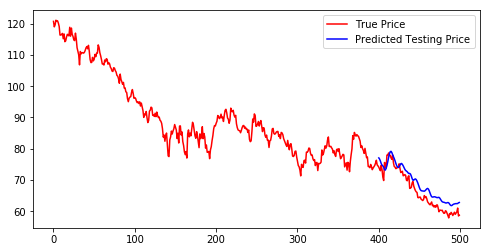

In [19]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df, color='red',  label="True Price")
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
plt.legend()

zooming in on the predictions and actual

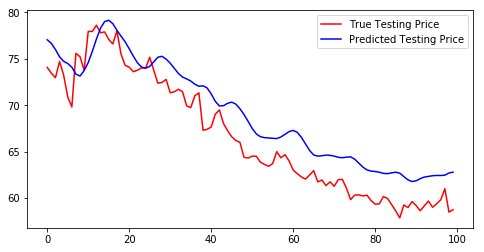

In [20]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()

In [27]:
pickle.dump(predictions,open('predictions.data','wb'))

### Calculating Residuals

Here we calculate the residual errors, which will allow us to plot Error bar plots and QQ plots.

In [21]:
residual_errors = y_test_scaled - predictions

Plotting error bar plots

<ErrorbarContainer object of 3 artists>

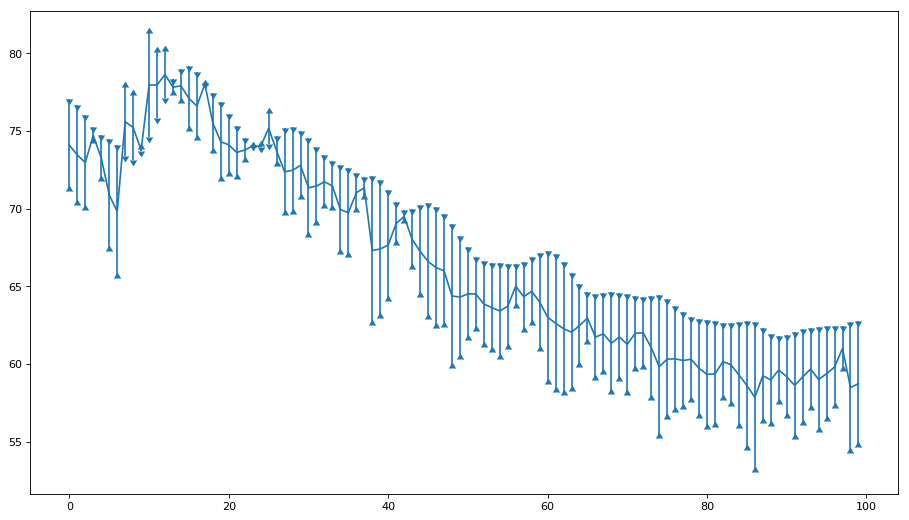

In [22]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(np.arange(len(y_test_scaled)),y_test_scaled,yerr=residual_errors,uplims=True, lolims=True)

Plotting QQ plot to see if the errors are normally distributed.

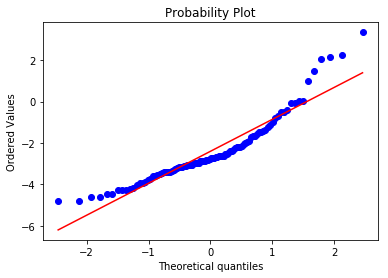

In [23]:
from scipy import stats
res = stats.probplot(residual_errors.flatten(), plot=plt)
plt.show()

### Observations:

From the QQ plot we can see that the errors have a curve and does nothave a linear fit. We will do the same for the model with the Twitter data.

We now calculate the mean and standard diviation to plot a normal curve.

In [24]:
mean = residual_errors.mean()
std_div = residual_errors.std()
print("Mean:"+str(mean)+" Std Div:"+str(std_div))

Mean:-2.407051885986329 Std Div:1.5964953514750642


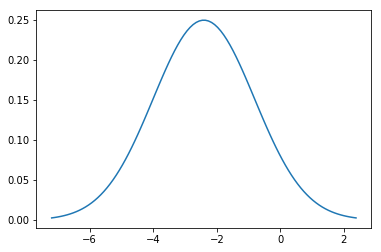

In [25]:
x = np.linspace(mean - 3*std_div, mean + 3*std_div, 100)
plt.plot(x, stats.norm.pdf(x, mean, std_div))
plt.show()

The bell curve seems to have the mean skewed to left 

Saving all the residuals. We will use that to compare with the new model.

In [26]:
pickle.dump(residual_errors,open('original_residual.data','wb'))

### Conclusion

Here we see that the predicted values are close to the actual values. As per the model the MSE is 0.0011 for 50 epochs and batch size 30. From the QQ plot we understand that the errors are not normally distributed. Next step would be to create a Neural network for sentimental analysis of twitter feed. And then creating an ensambled network of this LSTM and Sentimental Analysis Network to see if there is any positive change for predicting stock prices. 

### Contributions
1. Code contributed by me ~ 20% code
2. From other sources ~ 80% code

### Citation
1. [Stock Market Prediction by Recurrent Neural Network on LSTM Model](https://blog.usejournal.com/stock-market-prediction-by-recurrent-neural-network-on-lstm-model-56de700bff68)
2. [Stock market prediction](https://en.wikipedia.org/wiki/Stock_market_prediction)
3. [Stock Price Prediction using a Recurrent Neural Network](https://www.youtube.com/watch?v=lpU3PGyDKQ4)

<div class="alert alert-block alert-info">
MIT License 

Copyright (c) 2019 Ninad Subhedar 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: 

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software. 

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</div>